In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization 
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from sklearn.metrics import mean_squared_error

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-wuuo72/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-20 11:14:34.609681: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ds = xr.open_dataset('/work/bb1166/Edward/WRFOUT/IRENE/postproc/wrfout_SENEGAL_2019full_d03_v2.nc')
ds

<xarray.Dataset>
Dimensions:    (Time: 345601, lat: 222, lon: 399)
Coordinates:
  * Time       (Time) datetime64[ns] 2019-04-03T00:01:00 ... 2019-11-29T00:01:00
  * lat        (lat) float32 13.7 13.71 13.72 13.73 ... 15.66 15.67 15.68 15.69
  * lon        (lon) float32 -18.2 -18.19 -18.18 -18.17 ... -14.52 -14.51 -14.5
Data variables:
    RAIN_1MIN  (Time, lat, lon) float32 ...
    RAINNC     (Time, lat, lon) float32 ...
    I_RAINNC   (Time, lat, lon) float32 ...
    T2         (Time, lat, lon) float32 ...
    SMOIS      (Time, lat, lon) float32 ...
    Q2         (Time, lat, lon) float32 ...
    PSFC       (Time, lat, lon) float32 ...
    U10        (Time, lat, lon) float32 ...
    V10        (Time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.9

In [3]:
stations = dict(
    Pout=(14.763706039562928, -17.066131173817304),
    Dakar=(14.729758635332256, -17.47)
)

variables = ["T2", "RAIN_1MIN", "Q2", "SMOIS", "U10", "V10", "PSFC"]

station_datasets = []
for station_name, latlon in stations.items():
    print(station_name, latlon)
    lat, lon = latlon
    ds_station = ds.sel(lat=lat, lon=lon, method="nearest")[variables].chunk(Time=512)
    ds_station.coords["station_name"] = station_name
    station_datasets.append(ds_station)
    
ds_stations_data = xr.concat(station_datasets, dim="station_name")

ds_stations_data

Pout (14.763706039562928, -17.066131173817304)
Dakar (14.729758635332256, -17.47)


<xarray.Dataset>
Dimensions:       (station_name: 2, Time: 345601)
Coordinates:
  * Time          (Time) datetime64[ns] 2019-04-03T00:01:00 ... 2019-11-29T00...
    lat           (station_name) float32 14.76 14.73
    lon           (station_name) float32 -17.07 -17.47
  * station_name  (station_name) <U5 'Pout' 'Dakar'
Data variables:
    T2            (station_name, Time) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
    RAIN_1MIN     (station_name, Time) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
    Q2            (station_name, Time) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
    SMOIS         (station_name, Time) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
    U10           (station_name, Time) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
    V10           (station_name, Time) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
    PSFC          (station_name, Time) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.9

In [4]:
class MultiStepTimeSeriesGenerator():
    """
    Copied and edited from https://www.tensorflow.org/tutorials/structured_data/time_series
    """
    def __init__(self, 
                 input_width, 
                 label_width, 
                 shift,
                 df,
                 batch_size):

        # Work out the window parameters.
        self.input_width       = input_width
        self.label_width       = label_width
        self.shift             = shift
        self.batch_size        = batch_size
        self.total_window_size = input_width + label_width
        self.input_slice       = slice(0, input_width)
        self.labels_slice      = slice(self.total_window_size - self.label_width, None)
        
        # Preprocess the raw data into datasets
        val_split = 0.2
        self.train_df = df[0:int((len(df)-N_STEPS_OUT)*(1-val_split))]
        self.val_df = df[int((len(df)-N_STEPS_OUT)*(1-val_split))-N_STEPS_IN:-N_STEPS_OUT]
        self.test_df = df[-(N_STEPS_IN + N_STEPS_OUT):]

        self.train = self.make_dataset(self.train_df)
        self.val   = self.make_dataset(self.val_df)
        self.test  = self.make_dataset(self.test_df)

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        labels = tf.stack([labels[:, :, 0]], axis = -1)
    
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype = np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(data            = data,
                                                          targets         = None,
                                                          sequence_length = self.total_window_size,
                                                          sequence_stride = 1,
                                                          shuffle         = False,
                                                          batch_size      = self.batch_size)

        ds = ds.map(self.split_window)

        return ds

In [5]:
df_Dakar = ds_stations_data.sel(Time=slice('2019-09-01T00:00:00', '2019-09-15T00:00:00')).sel(station_name='Dakar').to_dataframe()
df_Pout = ds_stations_data.sel(Time=slice('2019-09-01T00:00:00', '2019-09-15T00:00:00')).sel(station_name='Pout').to_dataframe()

In [6]:
df_sample_Dakar = df_Dakar.drop('station_name', axis='columns')
df_sample_Pout = df_Pout.drop('station_name', axis='columns')

In [32]:
df_sample = df_sample_Pout

In [8]:
N_FEATURES  = 1  # univariate
N_STEPS_IN  = 60 # static window
N_STEPS_OUT = 30  # multi-step

In [34]:
time_series_datasetPout = MultiStepTimeSeriesGenerator(input_width = N_STEPS_IN, 
                                                   label_width = N_STEPS_OUT, 
                                                   shift       = 1, 
                                                   df          = df_sample_Pout, 
                                                   batch_size  = 32)

In [35]:
time_series_datasetDakar = MultiStepTimeSeriesGenerator(input_width = N_STEPS_IN, 
                                                   label_width = N_STEPS_OUT, 
                                                   shift       = 1, 
                                                   df          = df_sample_Dakar, 
                                                   batch_size  = 32)

In [36]:
time_series_datasetDakar

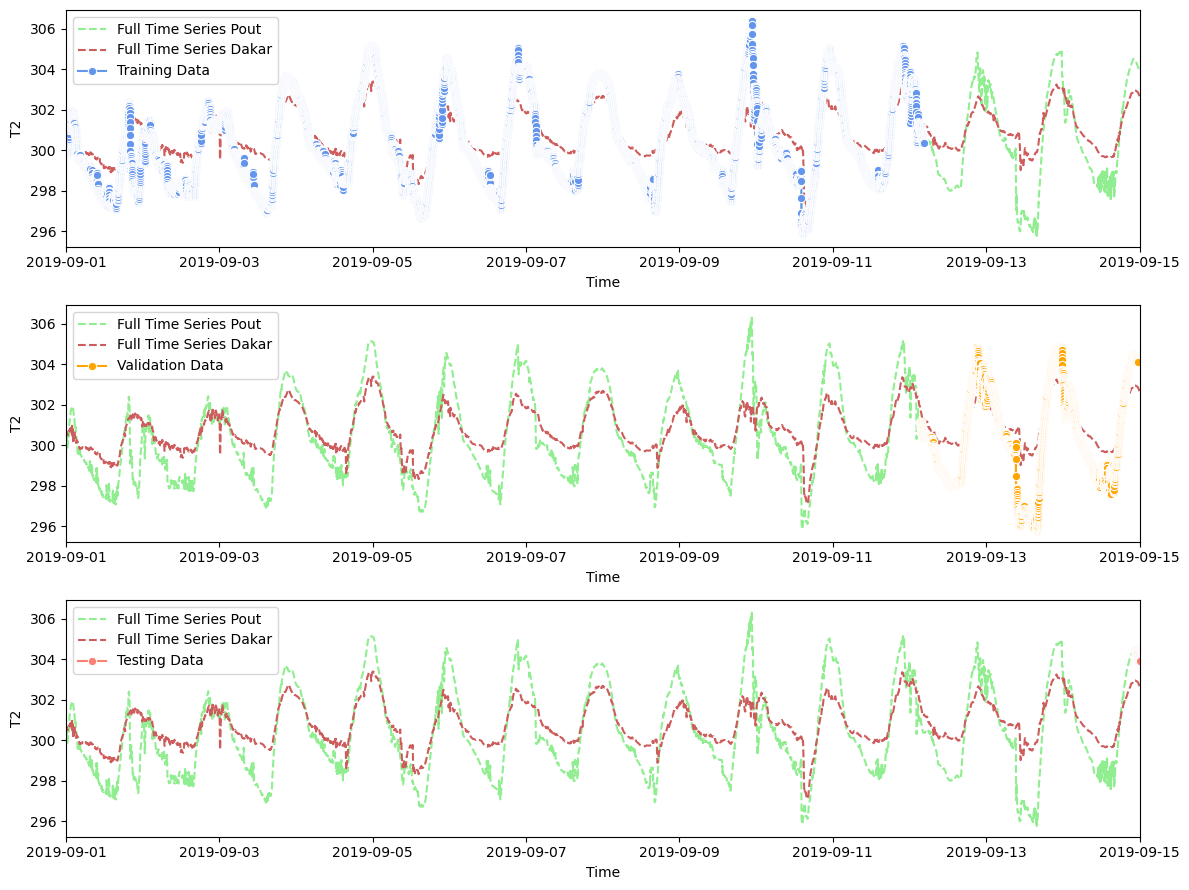

In [38]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))
time_series_dataset = time_series_datasetPout
for i in range(3):
    
    sns.lineplot(x=df_sample_Pout.index, y=df_sample_Pout.T2, color='lightgreen', marker=None, linestyle='dashed', label='Full Time Series Pout', ax=ax[i])
    sns.lineplot(x=df_sample_Dakar.index, y=df_sample_Dakar.T2, color='indianred', marker=None, linestyle='dashed', label='Full Time Series Dakar', ax=ax[i])

sns.lineplot(x=time_series_dataset.train_df.index, y=time_series_dataset.train_df.T2, color='cornflowerblue', marker='o', ax=ax[0], label='Training Data')
sns.lineplot(x=time_series_dataset.val_df.index, y=time_series_dataset.val_df.T2, color='orange', marker='o', ax=ax[1], label='Validation Data')
sns.lineplot(x=time_series_dataset.test_df.index, y=time_series_dataset.test_df.T2, color='salmon', marker='o', ax=ax[2], label = 'Testing Data')

for i in range(3):
    ax[i].set_xlim(df_sample.index[0], df_sample.index[-1])
    ax[i].legend(loc='upper left')
plt.tight_layout()
plt.show()

Inputs shape (batch, timesteps, features): (32, 60, 1)
Labels shape (batch, timesteps, features): (32, 30, 1)


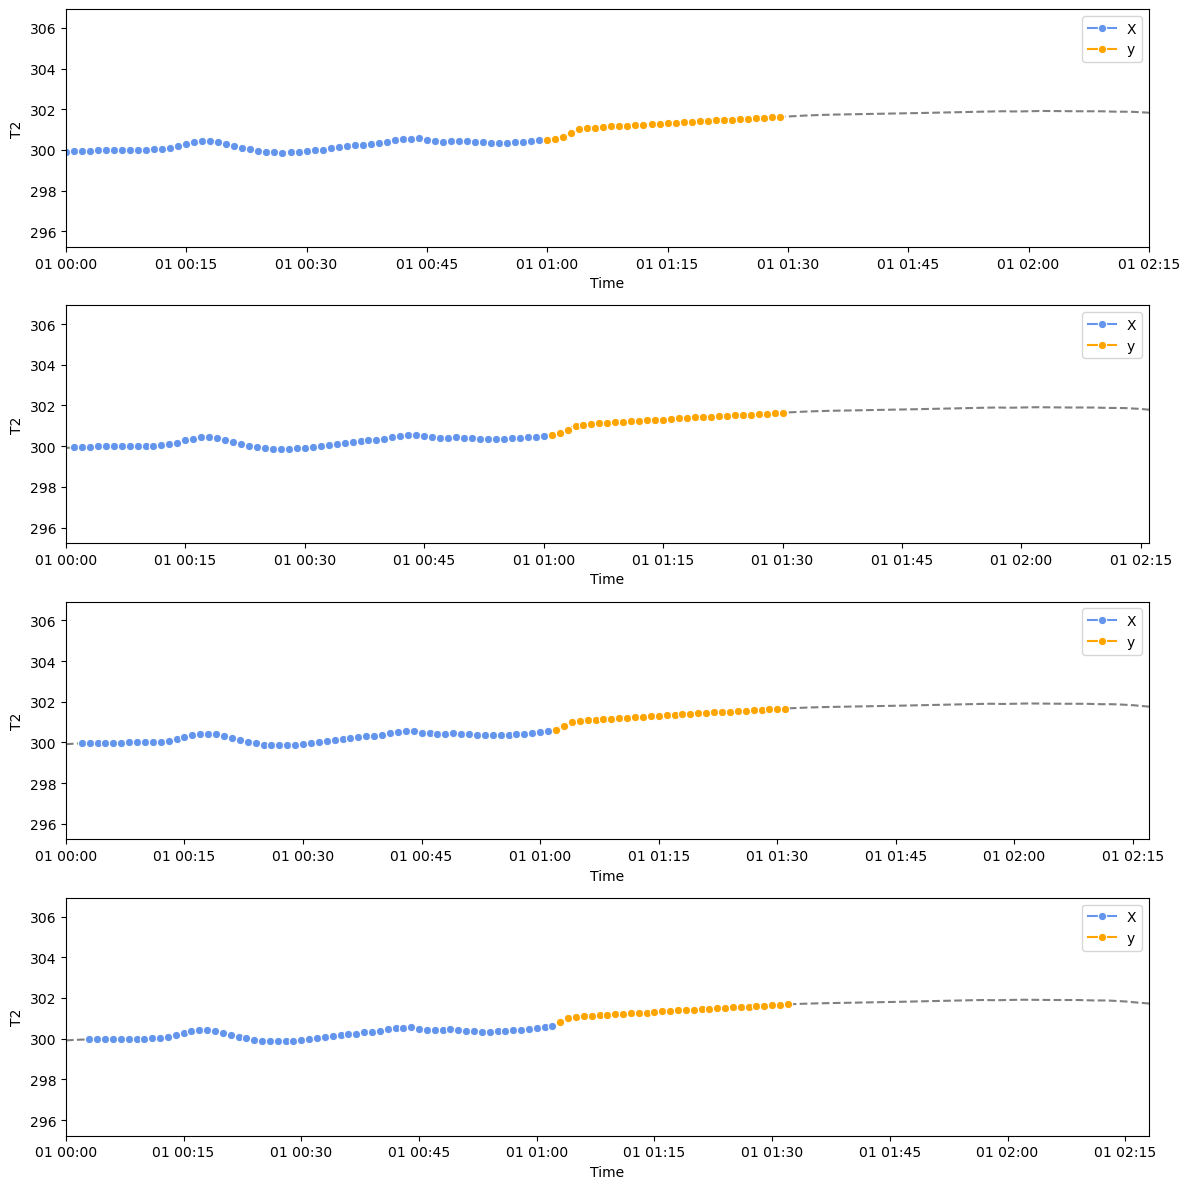

In [31]:
dataset_Pout = time_series_datasetPout.train
dataset_Dakar = time_series_datasetPout.train
example_inputs = list(dataset_Pout.as_numpy_iterator())[0][0][:,:,0]
example_labels = list(dataset_Pout.as_numpy_iterator())[0][1][:,:,0]
example_inputs = np.expand_dims(example_inputs, axis=2)
example_labels = np.expand_dims(example_labels, axis=2)
print(f'Inputs shape (batch, timesteps, features): {example_inputs.shape}')
print(f'Labels shape (batch, timesteps, features): {example_labels.shape}')

f, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 12))

for i in range(4):
    X_test = example_inputs[i]
    y_test = example_labels[i]

    sns.lineplot(data = df_sample_Pout, x = 'Time', y = 'T2', linestyle='dashed', color = 'grey', ax = ax[i])
    sns.lineplot(x=df_sample.index[i:(i+N_STEPS_IN)], y=X_test.reshape(-1), label='X', color='cornflowerblue', marker='o',ax = ax[i])
    sns.lineplot(x=df_sample.index[(i+N_STEPS_IN):(i+N_STEPS_IN+N_STEPS_OUT)], y=y_test.reshape(-1), label='y', color='orange', marker='o',ax = ax[i])
    ax[i].set_xlim(df_sample.index[0], df_sample.index[i+N_STEPS_IN+N_STEPS_OUT+45])
    ax[i].legend(loc='upper right')
plt.tight_layout()
plt.show()

In [15]:
SEED=2023
def baseline_model(lstm_units): 
    # Use initializers to initialize model parameters with the same values
    INITIALIZER_GLOROT_UNIFORM = tf.keras.initializers.GlorotUniform(seed=SEED)
    INITIALIZER_ORTHOGONAL = tf.keras.initializers.Orthogonal(gain = 1.0, seed=SEED)

    model = Sequential()
    model.add(LSTM(units                 = lstm_units, 
                   activation            = 'relu',
                   input_shape           = (N_STEPS_IN, N_FEATURES), 
                   kernel_initializer    = INITIALIZER_GLOROT_UNIFORM, 
                   recurrent_initializer = INITIALIZER_ORTHOGONAL))
    model.add(Dense(units              = N_STEPS_OUT,
                    kernel_initializer = INITIALIZER_GLOROT_UNIFORM))
    return model

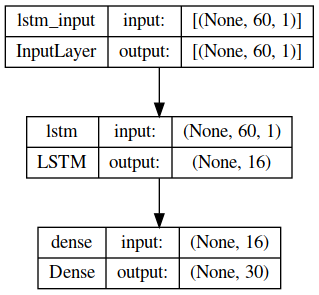

In [16]:
# Create model instance
model = baseline_model(16)

# Visualize model architecture
keras.utils.plot_model(model, show_shapes=True)


In [17]:
N_EPOCHS   = 100
BATCH_SIZE = 32

In [18]:
def evaluate_baseline(model, df, n_epochs = N_EPOCHS, verbose = 0):
    # Compile model
    model.compile(loss      = tf.losses.MeanSquaredError(),
                  optimizer = tf.optimizers.Adam(),
                  metrics   = [tf.metrics.MeanAbsoluteError()])
    
    # Create datasets from dataframe
    time_series_dataset = MultiStepTimeSeriesGenerator(input_width = N_STEPS_IN, 
                                              label_width = N_STEPS_OUT, 
                                              shift       = 1, 
                                              df          = df, 
                                              batch_size  = BATCH_SIZE)

    # Train model
    history = model.fit(time_series_dataset.train, 
                        validation_data = time_series_dataset.val,
                        epochs          = n_epochs,
                        batch_size      = BATCH_SIZE, 
                        verbose         = verbose, 
                        callbacks       = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                                           patience = 4),
                        shuffle         = False)

    # Make predictions on test set
    y_pred = model.predict(time_series_dataset.test, verbose=0)
    test_score = mean_squared_error(list(time_series_dataset.test.as_numpy_iterator())[0][1][0], y_pred.reshape(-1))
    test_score = np.round(test_score, 5)
    
    # Plot predictions
    ax = plot_loss_and_predictions(y_pred, history, n_epochs, df[['T2']])

    return test_score, ax

In [19]:
time        = np.arange(0, 100, 1)
### Build fictional time series for experimenting ###
df_sine = pd.DataFrame({'timestamp' : pd.date_range('2015-01-01', periods = len(time), freq='D'),
                   'feature' : 15*np.sin(0.2*time+10)+13,
                  })

# Create timestamps and set as index
df_sine.set_index('timestamp', inplace=True)
### Visualize time series ###
def plot_example_time_series(df, title = 'Example Time Series'):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))
    sns.lineplot(x=df.index, y=df.feature, color='grey', marker=None, linestyle='dashed')
    ax.set_xlim(df.index[0], df.index[-1])
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
#plot_example_time_series(df_sine[-365:], title = 'Example Time Series: Sine Wave (Last 365 Days)')
df_sample.head()

,T2,RAIN_1MIN,Q2,SMOIS,U10,V10,PSFC,lat,lon
Time,,,,,,,,,
2019-09-01 00:00:00,300.608612,0.0,0.017538,0.03,2.737913,0.766484,100670.500000,14.725876,-17.468525
2019-09-01 00:01:00,300.600372,0.0,0.017564,0.03,2.764872,0.822137,100671.703125,14.725876,-17.468525
2019-09-01 00:02:00,300.591858,0.0,0.017591,0.03,2.786030,0.871241,100671.523438,14.725876,-17.468525
2019-09-01 00:03:00,300.580505,0.0,0.017619,0.03,2.795206,0.912716,100669.414062,14.725876,-17.468525
2019-09-01 00:04:00,300.577057,0.0,0.017647,0.03,2.792349,0.945719,100666.359375,14.725876,-17.468525


In [20]:
df_T2 = df_sample_Pout[['T2']]
df_T2

,T2
Time,
2019-09-01 00:00:00,299.912201
2019-09-01 00:01:00,299.936157
2019-09-01 00:02:00,299.952332
2019-09-01 00:03:00,299.960968
2019-09-01 00:04:00,299.983124
...,...
2019-09-14 23:56:00,303.909210
2019-09-14 23:57:00,303.899231
2019-09-14 23:58:00,303.892334


In [21]:
def plot_loss_and_predictions(y_pred, history, n_epochs, df):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    sns.lineplot(x=np.arange(1, len(history.history['loss'])+1, 1), y=history.history['loss'], label='Training Loss', color='cornflowerblue', marker='o', ax=ax[0])
    sns.lineplot(x=np.arange(1, len(history.history['loss'])+1, 1), y=history.history['val_loss'], label='Validation Loss', color='orange', marker='o', ax=ax[0])

    ax[0].set_title('Model Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_xlim([1, n_epochs])
    ax[0].legend(loc='upper right')
    
    time_series_dataset = MultiStepTimeSeriesGenerator(input_width = N_STEPS_IN, 
                                          label_width = N_STEPS_OUT, 
                                          shift       = 1, 
                                          df          = df, 
                                          batch_size  = BATCH_SIZE)
    X_test = list(time_series_dataset.test.as_numpy_iterator())[0][0]
    y_test = list(time_series_dataset.test.as_numpy_iterator())[0][1]
    
    sns.lineplot(data = df, x = 'Time', y = 'T2', linestyle='dashed', color='grey', ax = ax[1])
    sns.lineplot(x=df.index[-(N_STEPS_IN + N_STEPS_OUT):-(N_STEPS_OUT)], y=X_test.reshape(-1), label='X', color='cornflowerblue', marker='o', ax = ax[1])
    sns.lineplot(x=df.index[-N_STEPS_OUT:], y=y_test.reshape(-1), label='y', color='orange', marker='o', ax = ax[1])
    sns.lineplot(x=df.index[-N_STEPS_OUT:], y=y_pred.reshape(-1), label='y_pred', color='salmon', marker='o', ax = ax[1])
    ax[1].set_xlim(df.index[-int((N_STEPS_IN + N_STEPS_OUT)*1.2)], df.index[-1])
    all_datapoints = df.iloc[-int((N_STEPS_IN + N_STEPS_OUT)*1.2):].values
    ax[1].set_ylim([all_datapoints.min()-1, all_datapoints.max()+1])
    ax[1].set_title(f'Prediction on Test Dataset with MSE {mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1)):.5f}')
    plt.tight_layout()
    
    return ax

In [22]:
def normalize_and_evaluate_baseline(model, df, n_epochs = N_EPOCHS, verbose = 0):
    # Compile model
    model.compile(loss      = tf.losses.MeanSquaredError(),
                  optimizer = tf.optimizers.Adam(),
                  metrics   = [tf.metrics.MeanAbsoluteError()])
    
    ##########################################################################
    # NEWLY ADDED
    ##########################################################################
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled['T2'] = scaler.fit_transform(df_scaled[['T2']])
    ##########################################################################

    # Create datasets from dataframe
    time_series_dataset = MultiStepTimeSeriesGenerator(input_width = N_STEPS_IN, 
                                              label_width = N_STEPS_OUT, 
                                              shift       = 1, 
                                              df          = df_scaled, 
                                              batch_size  = BATCH_SIZE)

    # Train model
    history = model.fit(time_series_dataset.train, 
                        validation_data = time_series_dataset.val,
                        epochs          = n_epochs,
                        batch_size      = BATCH_SIZE, 
                        verbose         = verbose, 
                        callbacks       = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                                          patience = 4),
                        shuffle         = False)


    # Make predictions on test set
    y_pred = model.predict(time_series_dataset.test, verbose=0)
    ##########################################################################
    # NEWLY ADDED
    ##########################################################################
    y_pred = scaler.inverse_transform(y_pred)
    test_score = mean_squared_error(scaler.inverse_transform(list(time_series_dataset.test.as_numpy_iterator())[0][1][0]), y_pred.reshape(-1))
    ##########################################################################
    test_score = np.round(test_score, 5)
    
    # Plot predictions
    ax = plot_loss_and_predictions(y_pred, history, n_epochs, df[['T2']])

    return test_score, ax

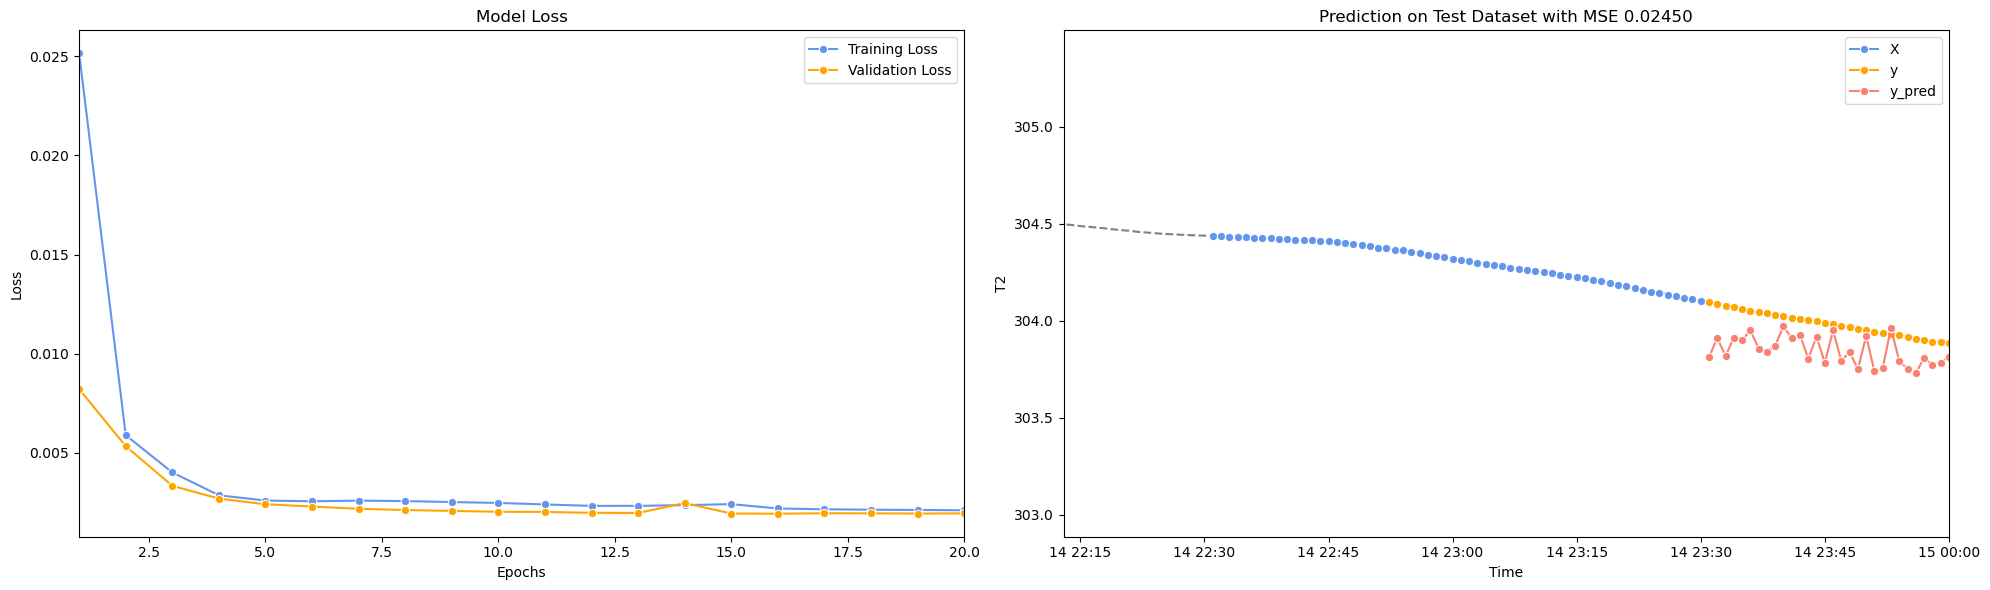

In [23]:
model = baseline_model(16)
_, _ = normalize_and_evaluate_baseline(model, df_T2, n_epochs = 20)

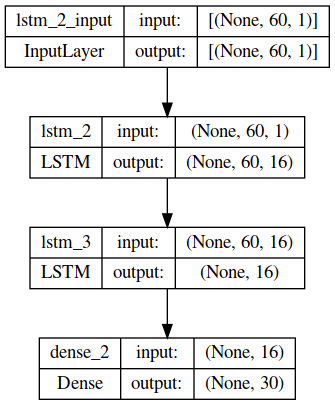

In [24]:
def model_with_stacked_lstm(lstm_units): 
    # Use initializers to initialize model parameters with the same values
    INITIALIZER_GLOROT_UNIFORM = tf.keras.initializers.GlorotUniform(seed = SEED)
    INITIALIZER_ORTHOGONAL = tf.keras.initializers.Orthogonal(gain = 1.0, seed = SEED)

    model = Sequential()
    
    model.add(LSTM(units                 = lstm_units, 
                   input_shape           = (N_STEPS_IN, N_FEATURES), 
                   kernel_initializer    = INITIALIZER_GLOROT_UNIFORM, 
                   recurrent_initializer = INITIALIZER_ORTHOGONAL,
    ##########################################################################
    # NEWLY ADDED
    # https://stackoverflow.com/questions/40331510/how-to-stack-multiple-lstm-in-keras
    ##########################################################################
                   return_sequences      = True)) 
    model.add(LSTM(units                 = lstm_units, 
                   kernel_initializer    = INITIALIZER_GLOROT_UNIFORM, 
                   recurrent_initializer = INITIALIZER_ORTHOGONAL))
    ##########################################################################
    
    model.add(Dense(units              = N_STEPS_OUT,
                    kernel_initializer = INITIALIZER_GLOROT_UNIFORM))
    return model

# Create model instance
model = model_with_stacked_lstm(16)

# Visualize model architecture
display(keras.utils.plot_model(model, show_shapes=True))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 32)            4352      
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 30)                990       
                                                                 
Total params: 13,662
Trainable params: 13,662
Non-trainable params: 0
_________________________________________________________________


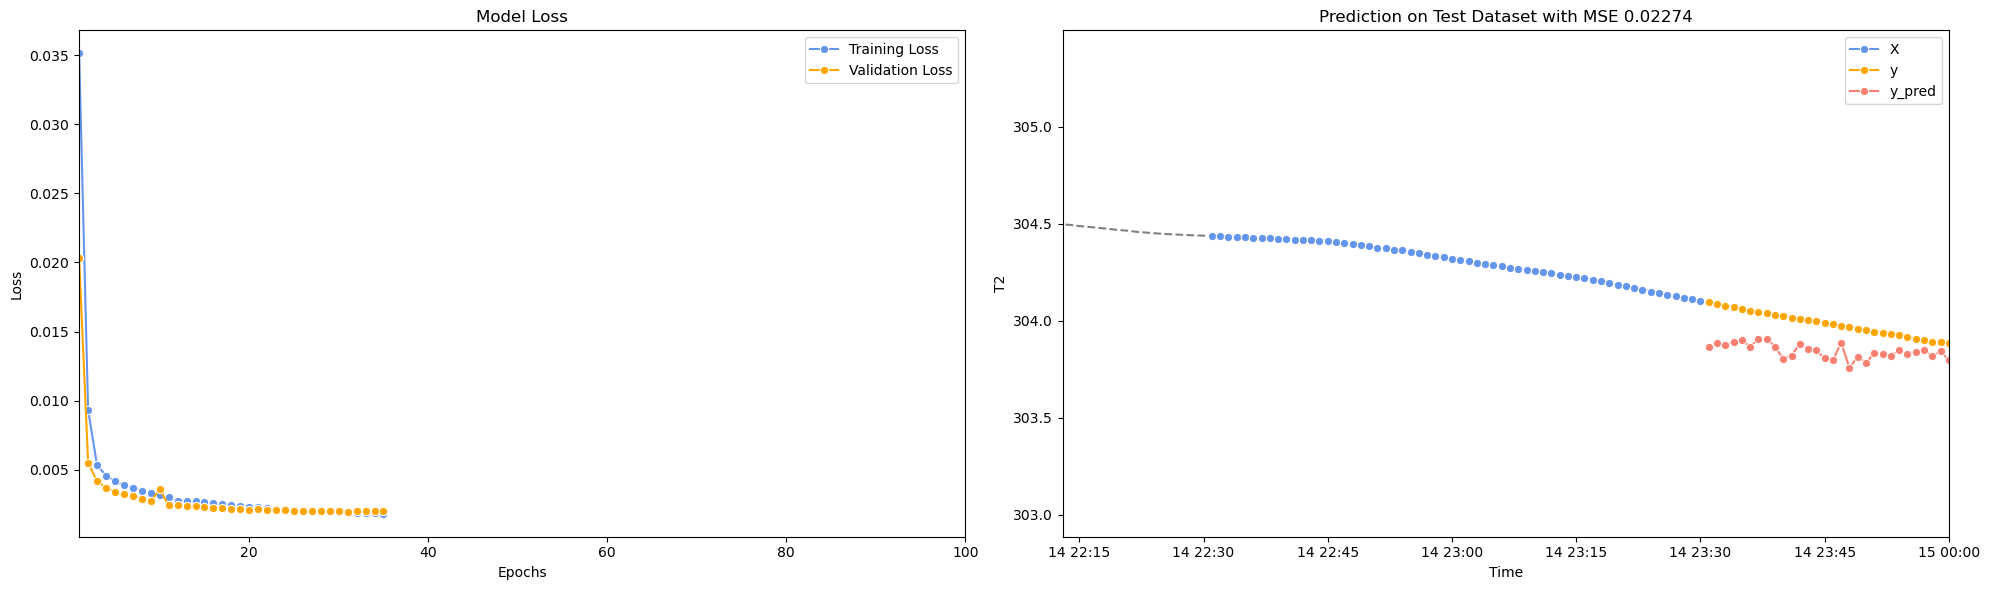

In [26]:
model = model_with_stacked_lstm(32)
model.summary()
_, _ = normalize_and_evaluate_baseline(model, df_T2)

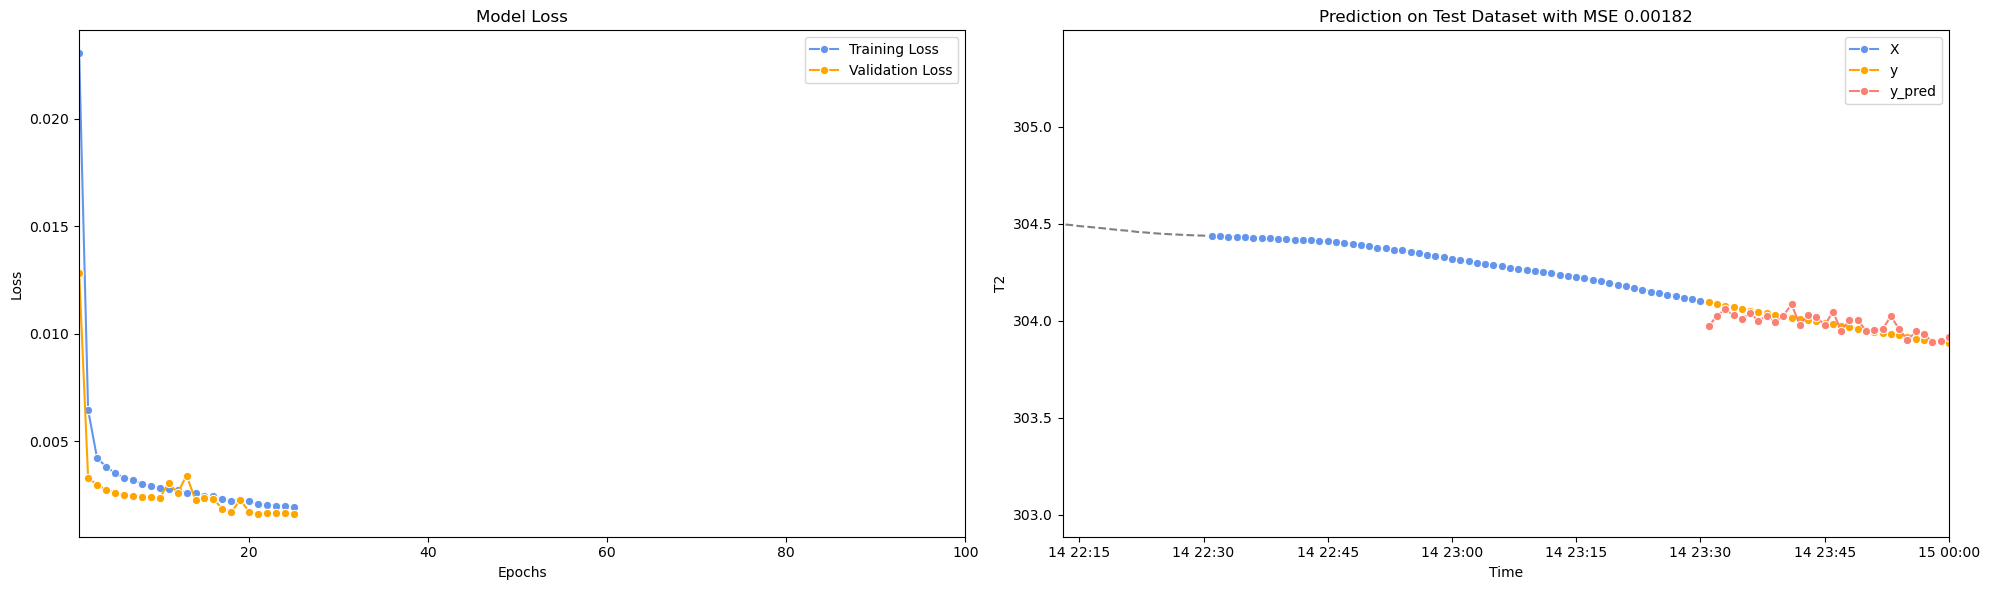

In [27]:
model = baseline_model(100)
_, ax = normalize_and_evaluate_baseline(model, df_T2)
plt.show()

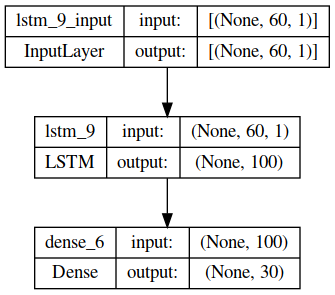

In [28]:
def model_with_dropout(lstm_units): 
    # Use initializers to initialize model parameters with the same values
    INITIALIZER_GLOROT_UNIFORM = tf.keras.initializers.GlorotUniform(seed = SEED)
    INITIALIZER_ORTHOGONAL = tf.keras.initializers.Orthogonal(gain = 1.0, seed = SEED)

    model = Sequential()
    model.add(LSTM(units                 = lstm_units, 
                   input_shape           = (N_STEPS_IN, N_FEATURES), 
                   activation            = 'relu',
                   kernel_initializer    = INITIALIZER_GLOROT_UNIFORM, 
                   recurrent_initializer = INITIALIZER_ORTHOGONAL,
    ##########################################################################
    # NEWLY ADDED
    ##########################################################################
                   recurrent_dropout     = 0.2,))
    ##########################################################################
    model.add(Dense(units              = N_STEPS_OUT,
                    kernel_initializer = INITIALIZER_GLOROT_UNIFORM))
    return model

# Create model instance
model = model_with_dropout(100)

# Visualize model architecture
display(keras.utils.plot_model(model, show_shapes=True))

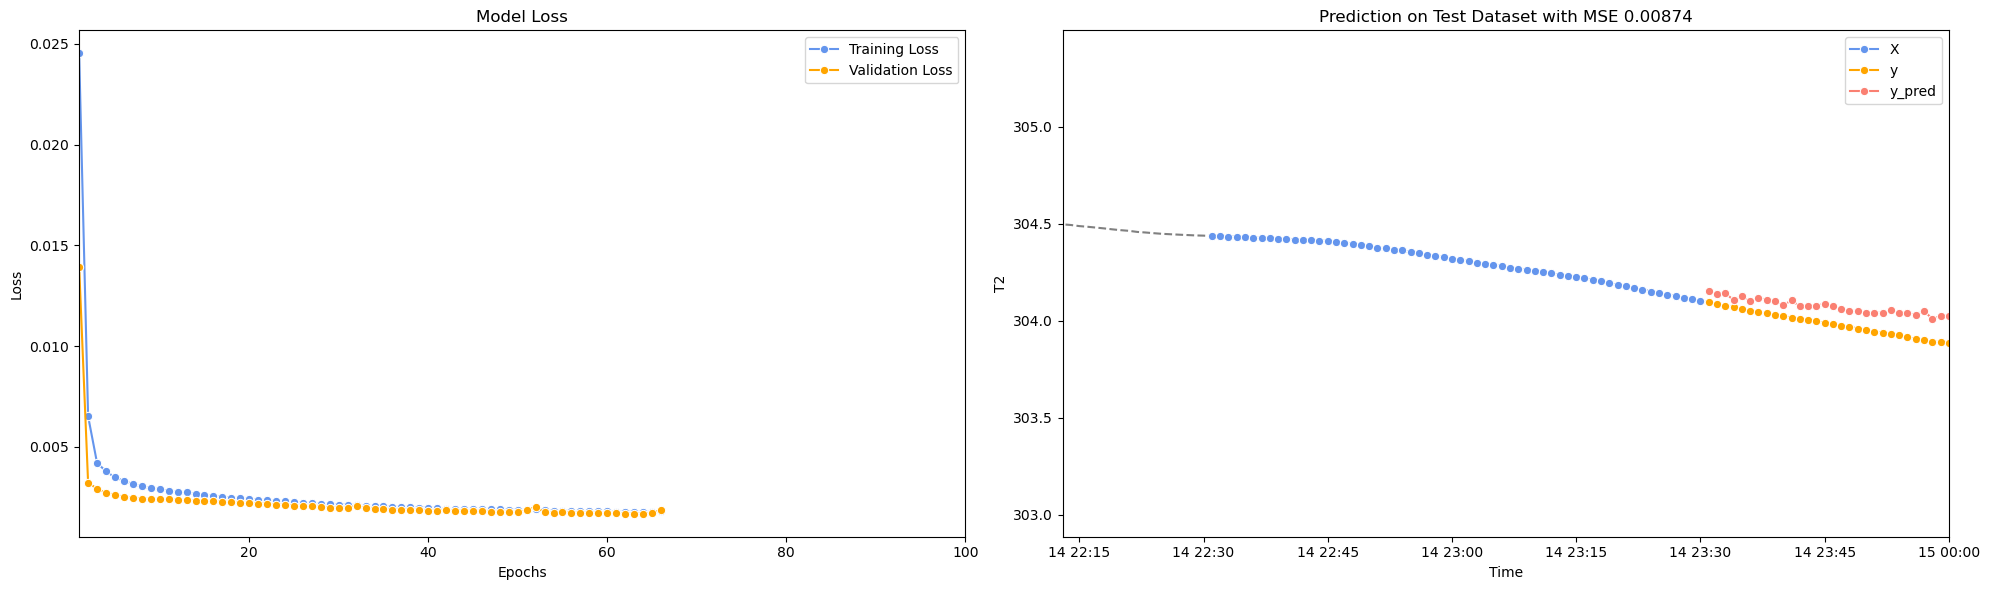

In [29]:
model = model_with_dropout(100)
_, ax = normalize_and_evaluate_baseline(model, df_T2)

In [ ]:
# Below I am stuck on making a good time series generator where 
# the input is Pout (temperature, humidity, wind...) 
# and the labels are from Dakar (temperature?)....

In [ ]:
class MultiStepTimeSeriesGenerator_2stations(df_upstream,df_downstream):
    """
    Copied and edited from https://www.tensorflow.org/tutorials/structured_data/time_series
    """
    def __init__(self, 
                 input_width, 
                 label_width, 
                 shift,
                 df,
                 batch_size):

        # Work out the window parameters.
        self.input_width       = input_width
        self.label_width       = label_width
        self.shift             = shift
        self.batch_size        = batch_size
        self.total_window_size = input_width + label_width
        self.input_slice       = slice(0, input_width)
        self.labels_slice      = slice(self.total_window_size - self.label_width, None)
        
        # Preprocess the raw data into datasets
        val_split = 0.2
        self.train_df = df[0:int((len(df)-N_STEPS_OUT)*(1-val_split))]
        self.val_df = df[int((len(df)-N_STEPS_OUT)*(1-val_split))-N_STEPS_IN:-N_STEPS_OUT]
        self.test_df = df[-(N_STEPS_IN + N_STEPS_OUT):]

        self.train = self.make_dataset(self.train_df)
        self.val   = self.make_dataset(self.val_df)
        self.test  = self.make_dataset(self.test_df)

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        labels = tf.stack([labels[:, :, 0]], axis = -1)
    
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype = np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(data            = data,
                                                          targets         = None,
                                                          sequence_length = self.total_window_size,
                                                          sequence_stride = 1,
                                                          shuffle         = False,
                                                          batch_size      = self.batch_size)

        ds = ds.map(self.split_window)

        return ds

In [ ]:
labels = features[:, self.labels_slice, :]
labels = tf.stack([labels[:, :, 0]], axis = -1)

In [ ]:
# Below I want to experiment with adding more feature, so we can include moisture, wind, etc from the Pout station

In [ ]:
N_FEATURES            = 2

In [ ]:
df_sample_Dakar

In [ ]:
df_inputPout_outputDakar()

In [ ]:
model = baseline_model(32)
_, _ = normalize_and_evaluate_baseline(model, df_PoutDakar)